
Exploratory Data Analysis for dataset1

Dataset Description:
           rownumber    customerid surname  creditscore geography gender  \
count    8000.000000  8.000000e+03    8000  8000.000000      8000   8000   
unique           NaN           NaN    2618          NaN         3      2   
top              NaN           NaN    Shih          NaN    France   Male   
freq             NaN           NaN      24          NaN      3994   4362   
mean     5012.506875  1.569067e+07     NaN   651.647625       NaN    NaN   
std      2887.649416  7.184743e+04     NaN    96.366200       NaN    NaN   
min         2.000000  1.556570e+07     NaN   350.000000       NaN    NaN   
25%      2512.750000  1.562822e+07     NaN   585.000000       NaN    NaN   
50%      5014.500000  1.569074e+07     NaN   653.000000       NaN    NaN   
75%      7505.250000  1.575316e+07     NaN   719.000000       NaN    NaN   
max     10000.000000  1.581566e+07     NaN   850.000000       NaN    NaN   

                age      

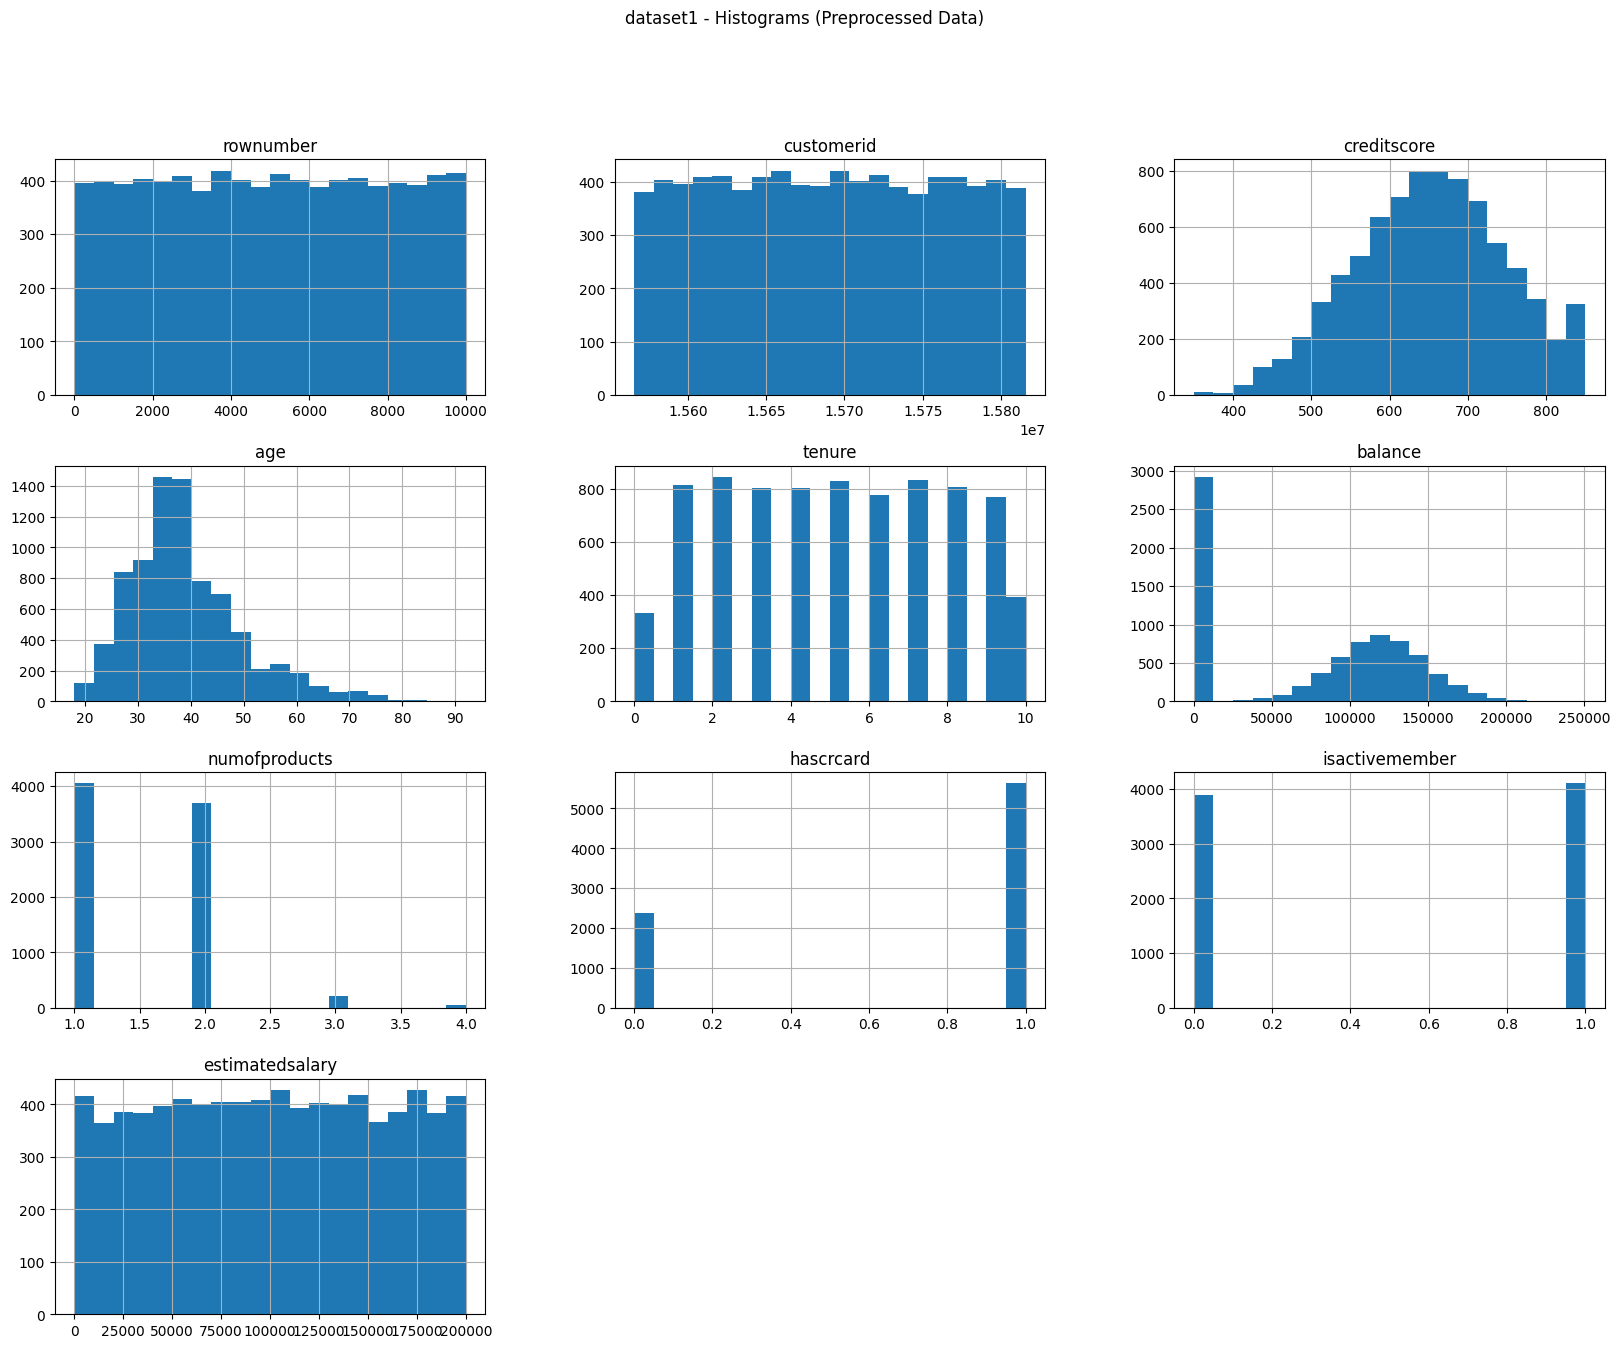

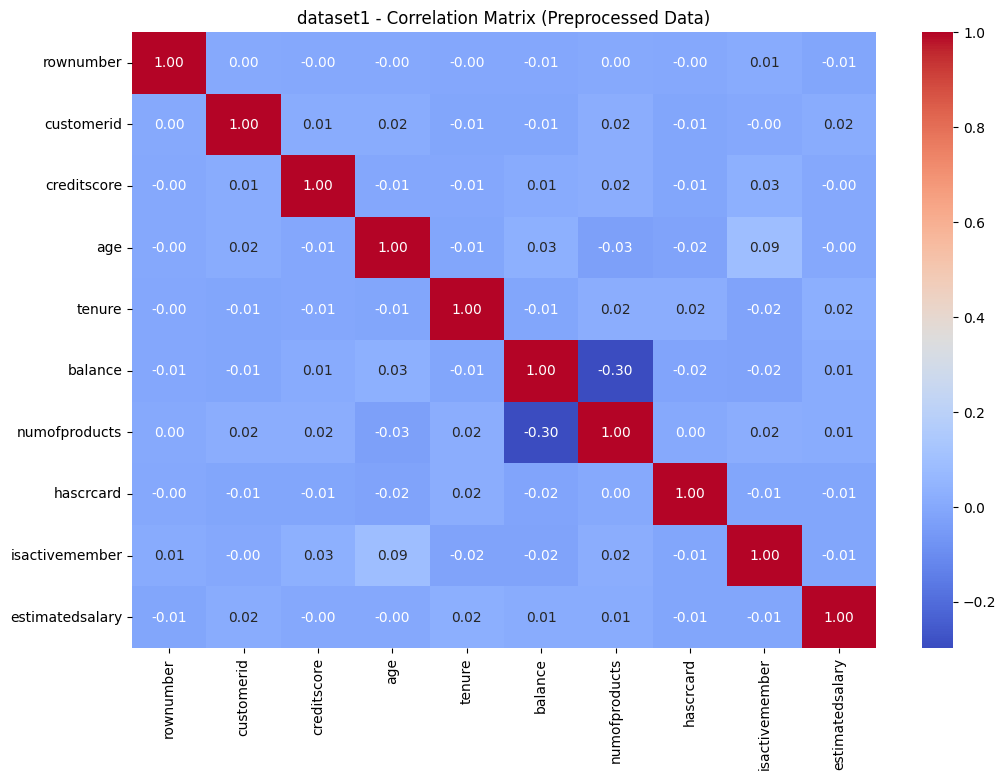


Training LogisticRegression for dataset1...

Training RandomForest for dataset1...

Training AdaBoost for dataset1...


c:\Users\dines\miniconda3\envs\DL\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Best Model: dataset1_AdaBoost
Accuracy on test set: 85.75%
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1607
           1       0.69      0.49      0.58       393

    accuracy                           0.86      2000
   macro avg       0.79      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000


Exploratory Data Analysis for dataset2

Dataset Description:
           clientnum  customer_age gender  dependent_count education_level  \
count   8.101000e+03   8101.000000   8101      8101.000000            8101   
unique           NaN           NaN      2              NaN               7   
top              NaN           NaN      F              NaN        Graduate   
freq             NaN           NaN   4279              NaN            2528   
mean    7.391329e+08     46.306382    NaN         2.334773             NaN   
std     3.691912e+07      8.022527    NaN         1.289564  

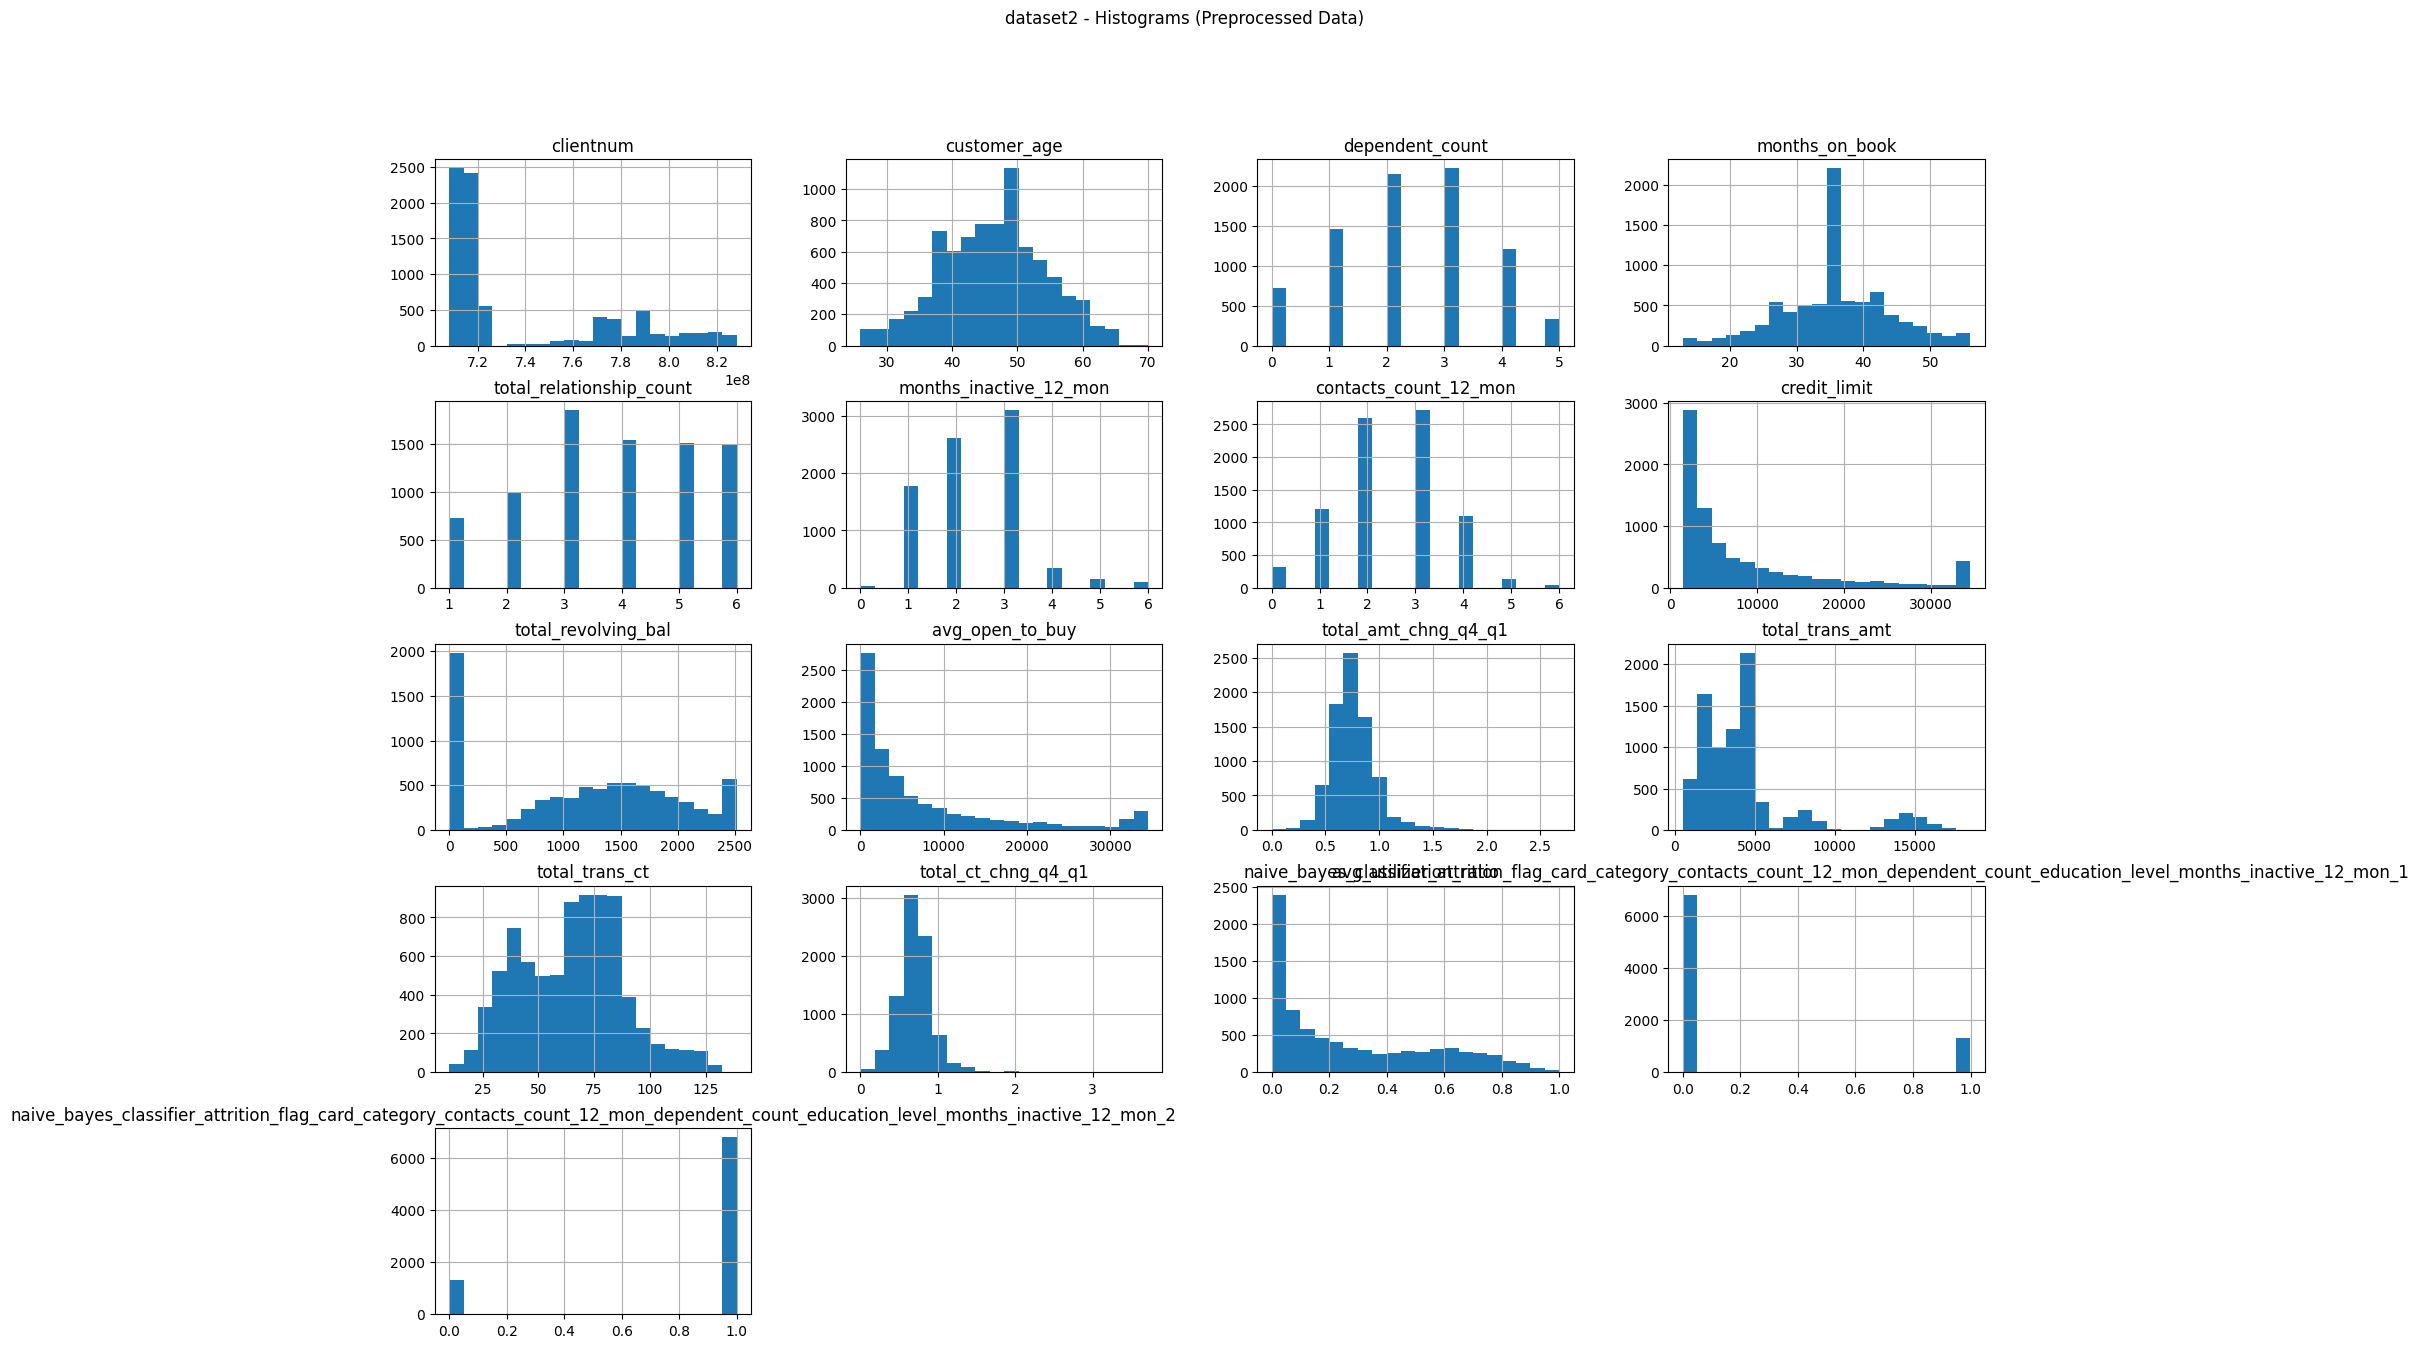

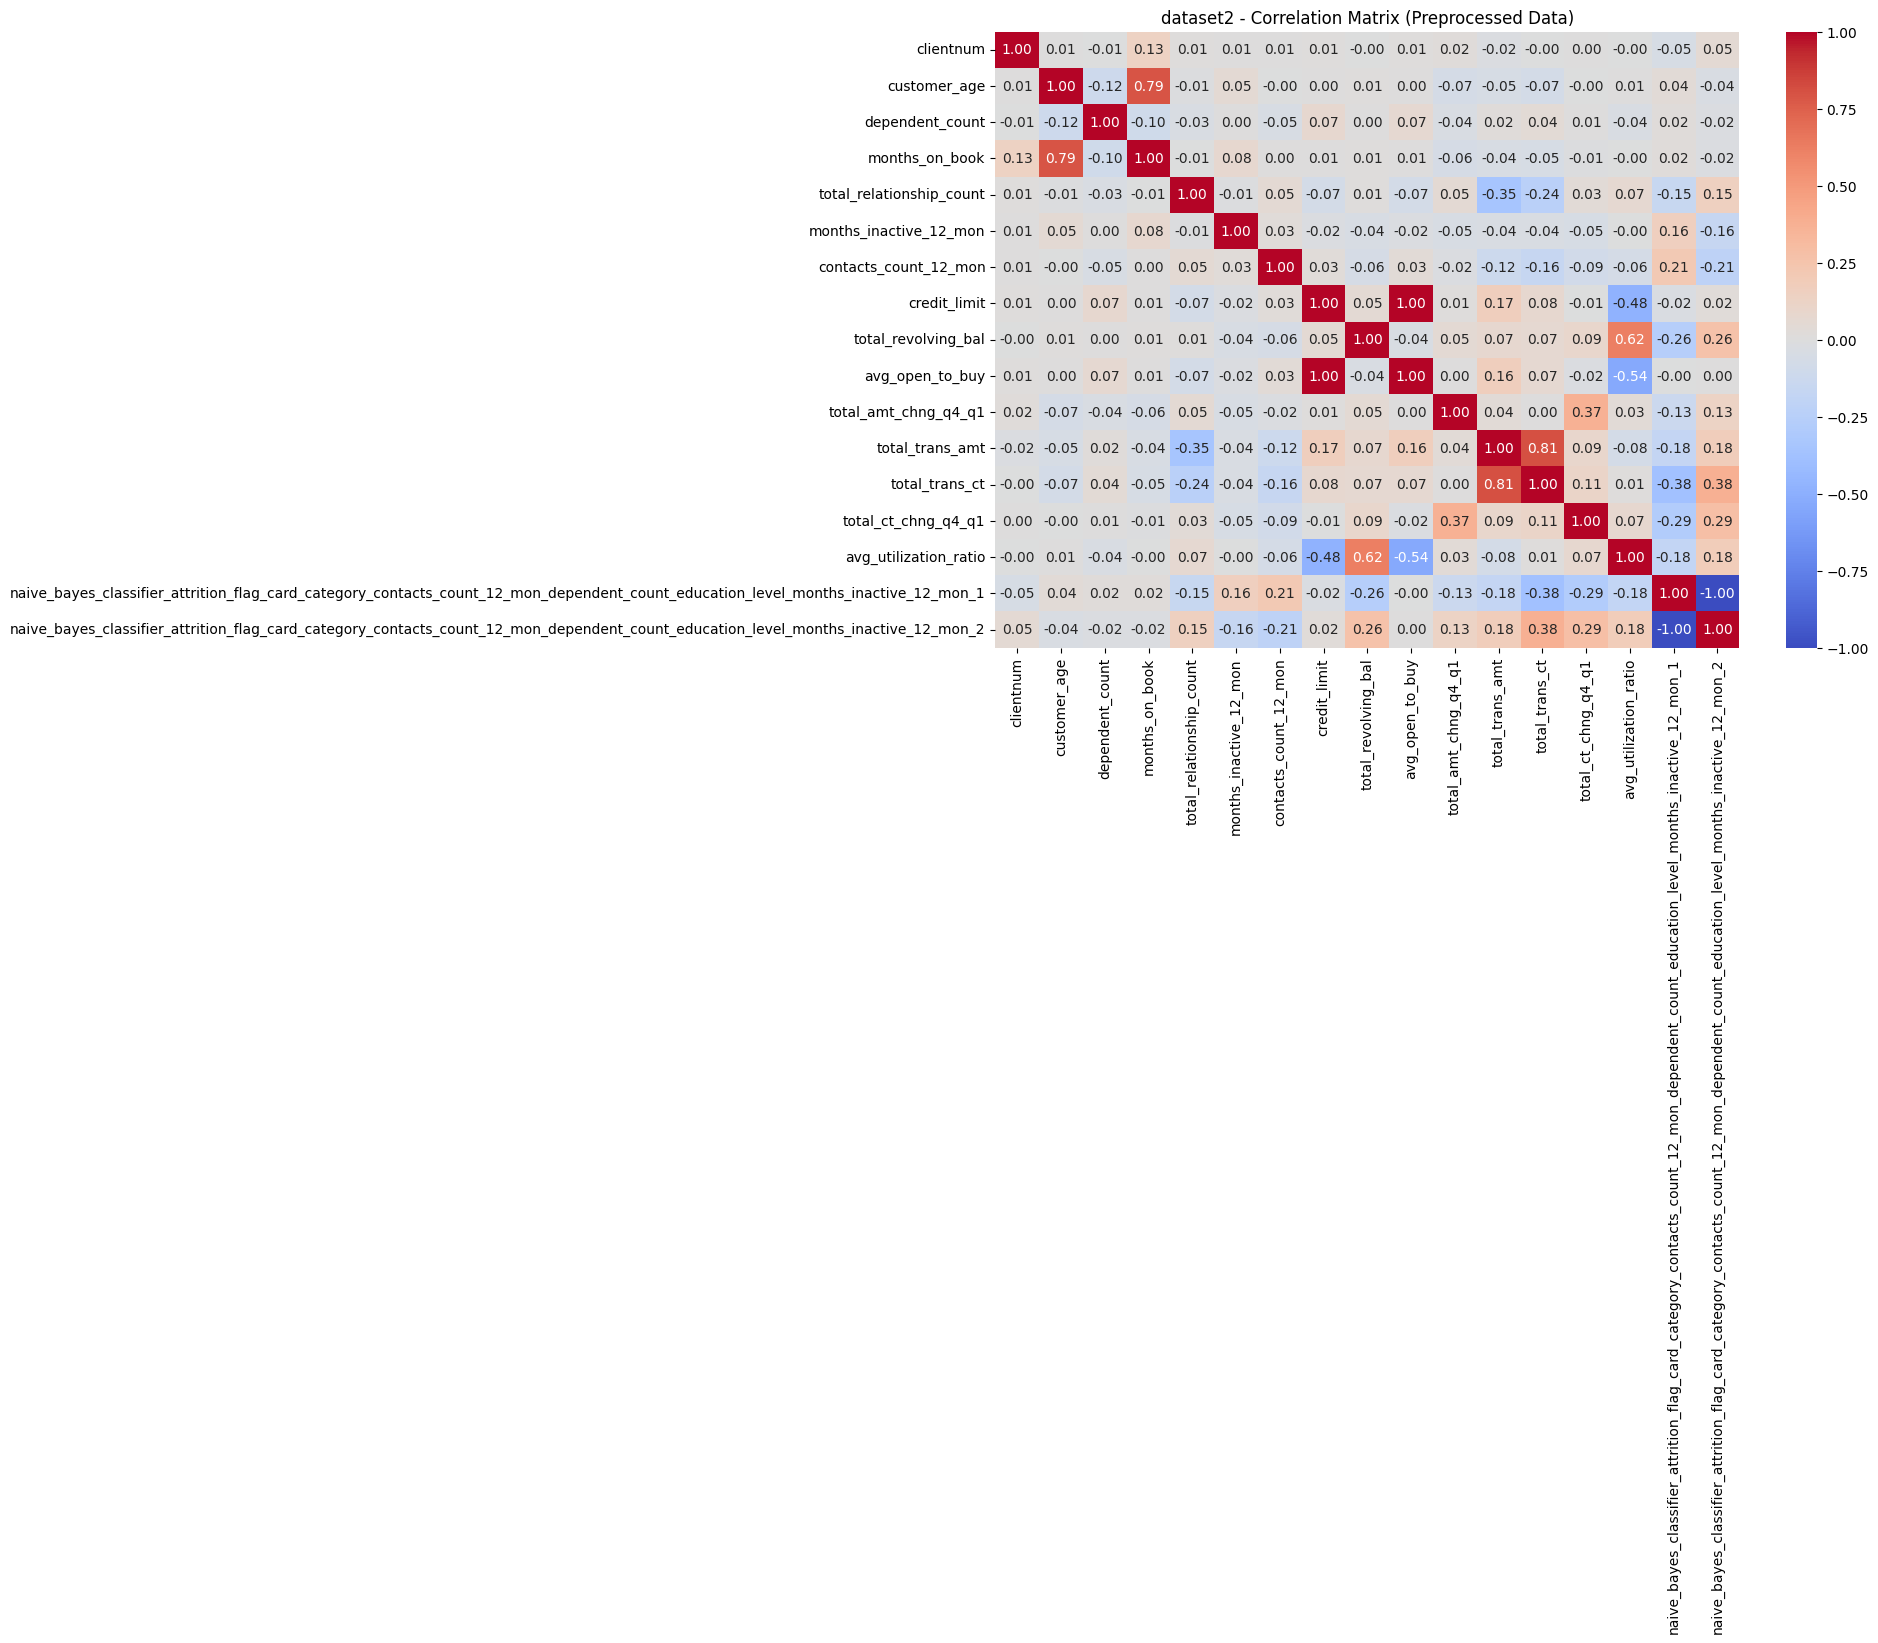


Training LogisticRegression for dataset2...

Training RandomForest for dataset2...

Training AdaBoost for dataset2...

Best Model: dataset2_LogisticRegression
Accuracy on test set: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1699
           1       1.00      1.00      1.00       327

    accuracy                           1.00      2026
   macro avg       1.00      1.00      1.00      2026
weighted avg       1.00      1.00      1.00      2026



c:\Users\dines\miniconda3\envs\DL\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report


datasets = {
    'dataset1': pd.read_csv('Dataset/Bank_churn.csv'),
    'dataset2': pd.read_csv('Dataset/BankChurners.csv')
}

class CustomPipeline:
    def __init__(self):
        self.pipelines = {}
        self.models = {}
        self.results = {}

    def perform_eda(self, X_train, y_train, dataset_name):
        print(f"\nExploratory Data Analysis for {dataset_name}")

        # Print dataset description
        print("\nDataset Description:")
        print(X_train.describe(include='all'))

        # Check and print null values
        null_counts = X_train.isnull().sum()
        print("\nNull Values in Features:")
        print(null_counts[null_counts > 0])

        # Check and print class distribution
        class_distribution = y_train.value_counts(normalize=True)
        print("\nClass Distribution (Churn):")
        print(class_distribution)
        
        # Plot histograms for numerical features
        numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
        X_train[numeric_features].hist(bins=20, figsize=(20, 15))
        plt.suptitle(f'{dataset_name} - Histograms (Preprocessed Data)')
        plt.show()

        # Correlation heatmap for numeric features only
        if numeric_features.size > 0:
            plt.figure(figsize=(12, 8))
            sns.heatmap(X_train[numeric_features].corr(), annot=True, fmt='.2f', cmap='coolwarm')
            plt.title(f'{dataset_name} - Correlation Matrix (Preprocessed Data)')
            plt.show()

    def preprocess_data(self, dataset_name, data):
        # Separate the target (churn) and the features
        X = data.drop(columns=['churn'])
        y = data['churn']
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test

    def create_pipeline(self, X_train, model):
        # Identify numeric and categorical columns
        numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
        categorical_features = X_train.select_dtypes(exclude=['float64', 'int64']).columns

        # Preprocessing for numeric data
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with mean
            ('scaler', StandardScaler())  # Normalize numeric data
        ])

        # Preprocessing for categorical data
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with most frequent
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical data to numeric using one-hot encoding
        ])

        # Combine preprocessing for numeric and categorical features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        # Feature selection using SelectKBest (k is tuned using GridSearchCV)
        feature_selector = SelectKBest(f_classif)

        # Create a pipeline with preprocessor, feature selection, and classifier
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('feature_selection', feature_selector),
            ('classifier', model)
        ])
        
    
        
        return pipeline

    def train_model(self, dataset_name, X_train, y_train):
        # Define models
        models = {
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
            'RandomForest': RandomForestClassifier(random_state=42),
            'AdaBoost': AdaBoostClassifier(random_state=42)
        }

        # Train multiple models and perform grid search for feature selection
        for model_name, model in models.items():
            print(f"\nTraining {model_name} for {dataset_name}...")
            pipeline = self.create_pipeline(X_train, model)
            
            # Grid search to find the best number of features
            param_grid = {
                'feature_selection__k': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,'all']
            }
            grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            
            best_pipeline = grid_search.best_estimator_
            best_score = grid_search.best_score_
            
            self.pipelines[dataset_name + '_' + model_name] = best_pipeline
            self.results[dataset_name + '_' + model_name] = best_score
            self.models[dataset_name + '_' + model_name] = best_pipeline

    def evaluate_model(self, dataset_name, X_test, y_test):
        # Get the best model based on accuracy
        best_model_name = max(self.results, key=self.results.get)
        best_model = self.models[best_model_name]
        
        # Make predictions
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        print(f"\nBest Model: {best_model_name}")
        print(f"Accuracy on test set: {accuracy * 100:.2f}%")
        print("Classification Report:")
        print(report)

# Initialize the custom pipeline class
pipeline = CustomPipeline()

# Loop over the datasets
for name, data in datasets.items():
    # Preprocess the data
    X_train, X_test, y_train, y_test = pipeline.preprocess_data(name, data)
    
    # Perform EDA after preprocessing
    pipeline.perform_eda(X_train, y_train, name)
    
    # Train multiple models and perform grid search for feature selection
    pipeline.train_model(name, X_train, y_train)
    
    # Evaluate models and print the best one
    pipeline.evaluate_model(name, X_test, y_test)
